In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


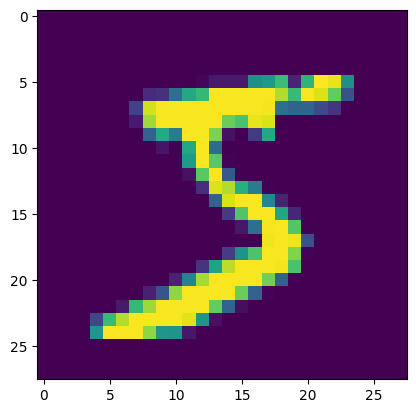

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

plt.imshow(X_train[0])

In [3]:
zeros = X_train[y_train==0]

zeros.shape

(5923, 28, 28)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.models import Sequential

discriminator = Sequential()
discriminator.add(Flatten(input_shape=[28,28]))
discriminator.add(Dense(400, activation='relu'))
discriminator.add(Dense(200, activation='relu'))
discriminator.add(Dense(100, activation='relu'))
discriminator.add(Dense(1, activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 400)            │       314,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        80,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 414,401 (1.58 MB)

 Trainable params: 414,401 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
encoding_size = 50

generator = Sequential()
generator.add(Dense(100, activation='relu', input_shape=[encoding_size]))
generator.add(Dense(200, activation='relu'))
generator.add(Dense(400, activation='relu'))
generator.add(Dense(28*28, activation='sigmoid'))
generator.add(Reshape([28,28]))

generator.compile(loss='binary_crossentropy', optimizer='adam')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
GAN=Sequential([generator, discriminator])
discriminator.trainable=False

GAN.compile(loss='binary_crossentropy', optimizer='adam')

discriminator.trainable=False

In [7]:
batch_size=32

data=zeros
dataset=tf.data.Dataset.from_tensor_slices(data).shuffle(buffer_size=1000)

dataset=dataset.batch(batch_size, drop_remainder=True).prefetch(1)

epochs=1

GAN.layers


[<Sequential name=sequential_1, built=True>,
 <Sequential name=sequential, built=True>]

In [19]:
generator, discriminator = GAN.layers

discriminator_optimizer = tf.keras.optimizers.Adam()
generator_optimizer = tf.keras.optimizers.Adam()

binary_crossentropy = tf.keras.losses.BinaryCrossentropy()

epochs=3

for epoch in range(epochs):
  print(f'Current epoch{epoch+1}')
  i=0

  for real_images in dataset:
    if i%100==0:
      print(f'Current batch{i+1} of {len(data)//batch_size}')

    # Entrenamiento del discriminador

    noise=tf.random.normal(shape=[batch_size, encoding_size])
    gen_images=generator(noise)

    fake_vs_real = tf.concat([gen_images, tf.dtypes.cast(real_images, tf.float32)], axis=0)
    labels = tf.concat([tf.zeros(shape=[batch_size, 1]), tf.ones(shape=[batch_size, 1])], axis=0) # Labels for fake (0) and real (1) images

    with tf.GradientTape() as discriminator_tape:
        predictions = discriminator(fake_vs_real)
        discriminator_loss = binary_crossentropy(labels, predictions)

    gradients_of_discriminator = discriminator_tape.gradient(discriminator_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


    # Entrenamiento del generador
    noise=tf.random.normal(shape=[batch_size, encoding_size])
    labels_2 = tf.ones(shape=[batch_size, 1]) # Target labels for generator (wants discriminator to output 1 for fake images)

    with tf.GradientTape() as generator_tape:
        gen_images = generator(noise)
        predictions = discriminator(gen_images)
        generator_loss = binary_crossentropy(labels_2, predictions)

    gradients_of_generator = generator_tape.gradient(generator_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    i+=1

Current epoch1
Current batch1 of 185
Current batch101 of 185
Current epoch2
Current batch1 of 185
Current batch101 of 185
Current epoch3
Current batch1 of 185
Current batch101 of 185


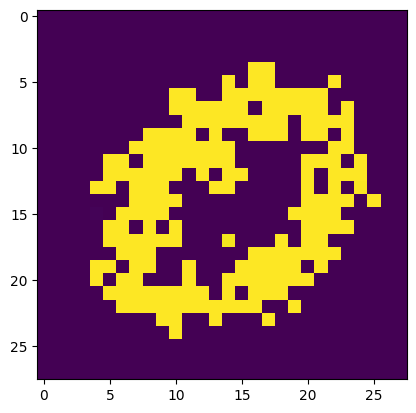

In [23]:
# Imagenes creadas por la red

noise = tf.random.normal(shape=[10, encoding_size])
generated_images = generator(noise)

plt.imshow(generated_images[0])
